## A short analysis of the compressive strength of concrete. 
> Dataset from https://www.kaggle.com/datasets/sinamhd9/concrete-comprehensive-strength

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from timeit import default_timer as timer

df = pd.read_excel('data/Concrete_Data.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

array([[<AxesSubplot:title={'center':'Cement (component 1)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Fly Ash (component 3)(kg in a m^3 mixture)'}>],
       [<AxesSubplot:title={'center':'Water  (component 4)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Superplasticizer (component 5)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Coarse Aggregate  (component 6)(kg in a m^3 mixture)'}>],
       [<AxesSubplot:title={'center':'Fine Aggregate (component 7)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Age (day)'}>,
        <AxesSubplot:title={'center':'Concrete compressive strength(MPa, megapascals) '}>]],
      dtype=object)

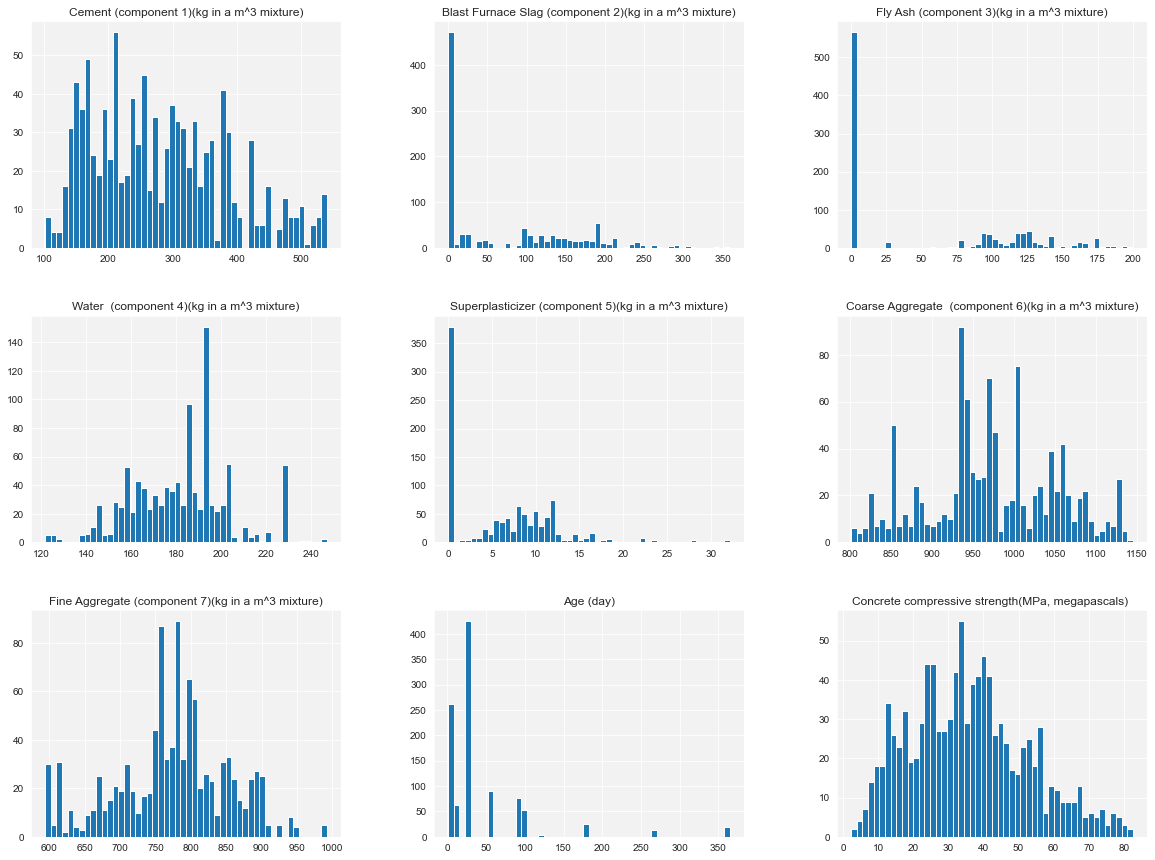

In [3]:
df.hist(bins=50, figsize=(20, 15))

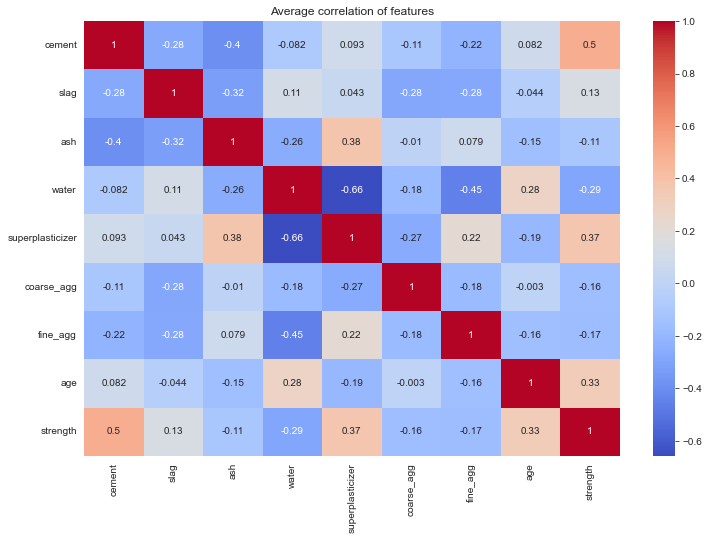

strength            1.000000
cement              0.497833
superplasticizer    0.366102
age                 0.328877
slag                0.134824
ash                -0.105753
coarse_agg         -0.164928
fine_agg           -0.167249
water              -0.289613
Name: strength, dtype: float64

In [4]:
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age', 'strength']

plt.figure(figsize=(12, 8))
plt.title('Average correlation of features')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

df.corr()['strength'].sort_values(ascending=False)


In [5]:
def calc_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

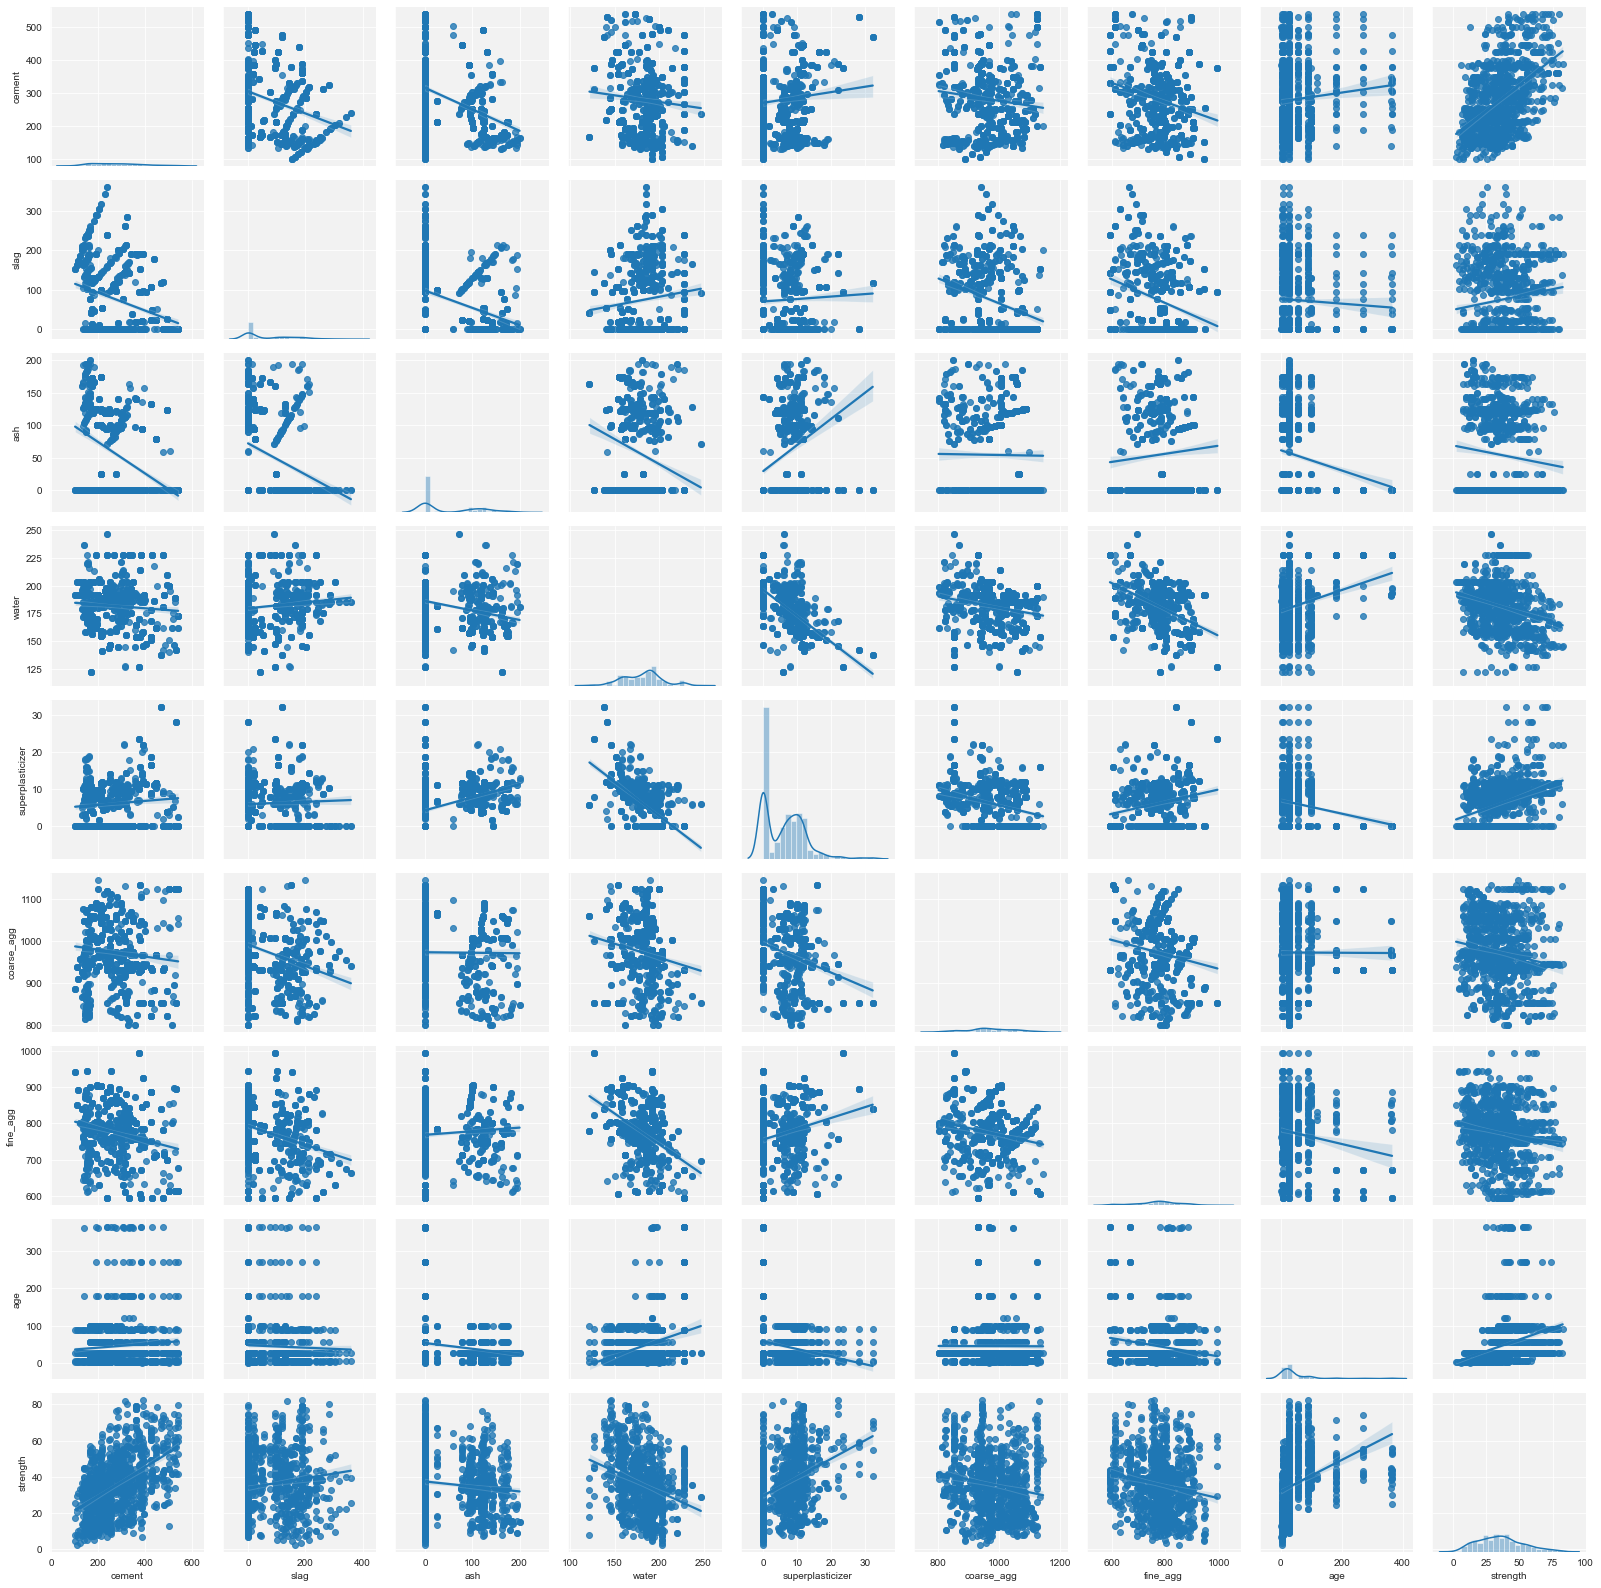

In [21]:
columns = df.columns.drop(['strength'])

# for i in range(len(columns)):
#     sns.jointplot(x=columns[i],
#                   y='strength',
#                   data=df,
#                   kind='reg',
#                   color=sns.color_palette("Paired", 8)[i])


g = sns.PairGrid(df, palette='Paired')
g.map_offdiag(sns.regplot)
g.map_diag(sns.distplot, bins=20)
    
# plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('strength', axis=1), df['strength'], test_size=0.2, random_state=0)

model = LinearRegression()
scaler = StandardScaler()
steps = [('scaler', scaler), ('regressor', model)]
pipeline = Pipeline(steps)

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10)
print(cv_results)
np.mean(cv_results)

[0.57652993 0.62303922 0.63103482 0.5849102  0.5273293  0.61677468
 0.51247014 0.68659326 0.54133102 0.65621386]


0.5956226437077506

In [7]:
fe_df = df.copy()

fe_df['total'] = df.drop(['strength'], axis=1).sum(axis=1)

fe_df['cement_ratio'] = fe_df['cement'] / fe_df['total']
fe_df['water_ratio'] = fe_df['water'] / fe_df['total']
fe_df['agg_ratio'] = (fe_df['coarse_agg'] + fe_df['fine_agg']) / fe_df['total']

fe_df['ageRoot'] = fe_df['age'] ** (1/2)
fe_df['superplasticizerRoot'] = fe_df['superplasticizer'] ** (1/2)
fe_df['totalRoot'] = fe_df['total'] ** (1/2)

fe_X = fe_df.drop(['strength'], axis=1)
fe_y = fe_df['strength']
# fe_df.head()

In [9]:
fe_mi_scores = calc_mi_scores(fe_X, fe_y)
fe_mi_scores

# fe_df.corr()['strength'].sort_values(ascending=False)

total                   0.565168
totalRoot               0.564756
agg_ratio               0.511069
water_ratio             0.443959
cement_ratio            0.371963
ageRoot                 0.361893
water                   0.359897
age                     0.356324
cement                  0.310481
coarse_agg              0.261761
superplasticizer        0.220181
superplasticizerRoot    0.217475
fine_agg                0.210665
slag                    0.178213
ash                     0.122771
Name: MI Scores, dtype: float64

In [10]:
def model_tester(df, models):
    results = {"ModelName" : [], "MeanCVScore" : [], "StdCVScore" : []}
    for i in range(len(models)):
        start = timer()
        
        X = df.drop('strength', axis=1)
        y = df['strength']
        scaler = StandardScaler()
        model = models[i]
        steps = [('scaler', scaler), ('regressor', model)]
        pipeline = Pipeline(steps)
        
        cv_results = cross_val_score(pipeline, X, y, cv=5)
        
        end = timer()
        
        print(f'{model.__class__.__name__} CV score: {cv_results.mean():.4f} +/- {cv_results.std():.4f} Time: {(end - start):.2f}s')
        
        results["ModelName"].append(model.__class__.__name__)
        results["MeanCVScore"].append(cv_results.mean())
        results["StdCVScore"].append(cv_results.std())
        
    return results

LinearRegression CV score: 0.7358 +/- 0.0975 Time: 0.01s
Lasso CV score: 0.7163 +/- 0.1241 Time: 0.26s
XGBRegressor CV score: -1.5786 +/- 0.7392 Time: 0.28s


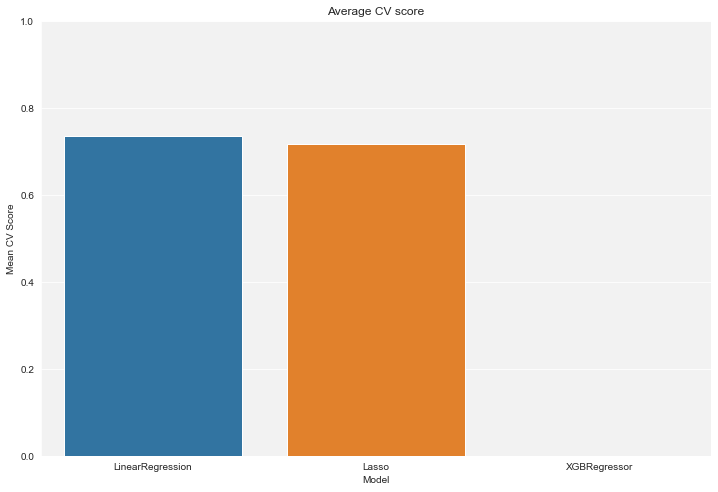

In [11]:
constant_state = 2137

models = [LinearRegression(n_jobs=4),
          Lasso(max_iter=5000, alpha=0.05, random_state=constant_state), 
          XGBRegressor(n_estimators=10, learning_rate=0.05, n_jobs=4, random_state=constant_state)
          ]

results = model_tester(fe_df, models)

results_df = pd.DataFrame(results)

results_df.head()

plt.figure(figsize=(12, 8))
plt.title('Average CV score')
ax = sns.barplot(x='ModelName', y='MeanCVScore', data=results_df)
ax.set(xlabel='Model', ylabel='Mean CV Score', ylim=(0, 1))
plt.show()
